In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

import model_prep_and_evals as mpe 
import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

import geopandas as gpd
import rioxarray as rioxr

import rasterio
from rasterio.crs import CRS

from shapely.geometry import box

import planetary_computer as pc

from skimage.feature import graycomatrix, graycoprops

In [2]:
box_carp = Polygon( [
            [-119.5144546684841,34.39274397377842],
            [-119.5144546684841,34.39193499538564],
            [-119.51344346289721,34.39193499538564],
            [-119.51344346289721,34.39274397377842],
            [-119.5144546684841,34.39274397377842]
          ])
itemid_carp = 'ca_m_3411936_se_11_060_20200521'

raster = sr.rioxr_from_itemid(itemid_carp, box_carp, "EPSG:4326")


In [3]:
raster

<xarray.DataArray (band: 4, y: 154, x: 160)>
[98560 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.688e+05 2.688e+05 ... 2.689e+05 2.689e+05
  * y            (y) float64 3.809e+06 3.809e+06 ... 3.808e+06 3.808e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [5]:
x = 20
y = 20
window = raster[:, y-window_r:y+window_r+1, x-window_r:x+window_r+1]
window

<xarray.DataArray (band: 4, y: 3, x: 3)>
[36 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.689e+05 2.689e+05 2.689e+05
  * y            (y) float64 3.809e+06 3.809e+06 3.809e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0
    datetime:                  2020-05-21 00:00:00+00:00

In [10]:
for angle in angles:
    print(contrast[angle].shape)

(4, 154, 160)
(4, 154, 160)


In [15]:
window_r = 1

# parameters for GLCM 
distances = [1]     
angles = [0, np.pi/2] # East, North

# these are ordered as they appear in the for loop calculating correlation and contrast
glcm_columns = ['r_contE', 'r_corrE', 'g_contE', 'g_corrE', 'b_contE', 'b_corrE', 'nir_contE', 'nir_corrE',
           'r_contN', 'r_corrN', 'g_contN', 'g_corrN', 'b_contN', 'b_corrN', 'nir_contN', 'nir_corrN']

y_len = raster.shape[1]
x_len = raster.shape[2]

In [11]:
# access a pixel

# make raster window around pixel

# calculate glcm on each band of window

# save value in corresponding texture band


contrast = {angles[0]: np.zeros((4,y_len,x_len)), 
            angles[1]: np.zeros((4,y_len,x_len))}

correlation = {angles[0]: np.zeros((4,y_len,x_len)), 
               angles[1]: np.zeros((4,y_len,x_len))}

for y in range(y_len):
    for x in range(x_len):
        # this window has shape (4, 2*window_r +1, 2*window_r +1)
        window = raster[:, y-window_r:y+window_r+1, x-window_r:x+window_r+1]

        # check that the window has desired size (no edges)
        if (window.shape[1] != 2*window_r+1) | (window.shape[2] != 2*window_r+1):
            contrast[y,x] = np.nan
            correlation[y,x] = np.nan  
        else:            

        # calculate GLCM on that small window, all bands
        # calculate the contrast and correlation on that window (all angles)
        # add these as features for that pixel 
                
            for angle in angles:
                for band in range(4):
                    glcm = graycomatrix(window[band],  # can only calculate one band at a time
                                distances=distances,
                                angles=[angle])
                    
                    # extract contrast and correlation from GLCM
                    contrast[angle][band,y,x] = graycoprops(glcm, 'contrast')[0,0]
                    correlation[angle][band,y,x] = graycoprops(glcm, 'correlation')[0,0]

        # since we are only generating glcm features for small windows, 
        # we do not need to save these as aux rasters to save memory
        

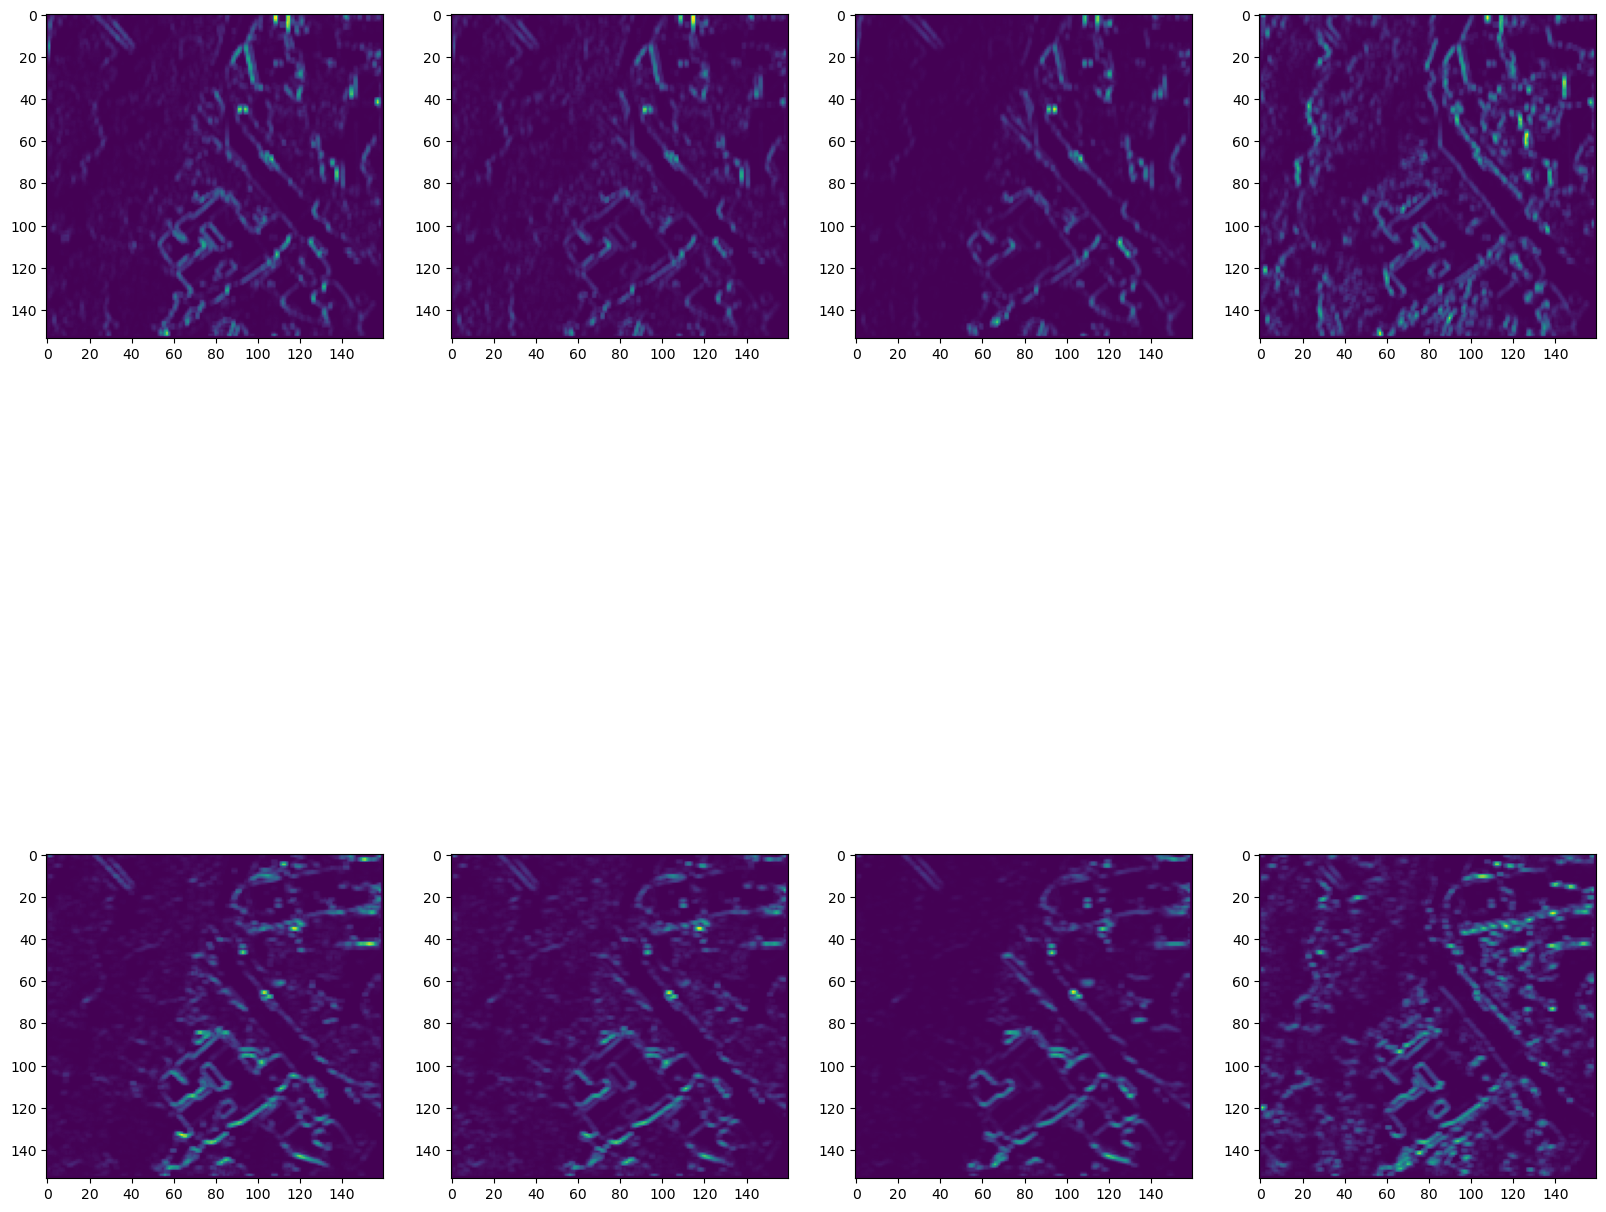

In [28]:
fig, ax = plt.subplots(2,4,figsize=(20, 20))  

for i,angle in zip(range(2),angles):
    for band in range(4):
        ax[i,band].imshow(contrast[angle][band])
plt.show()

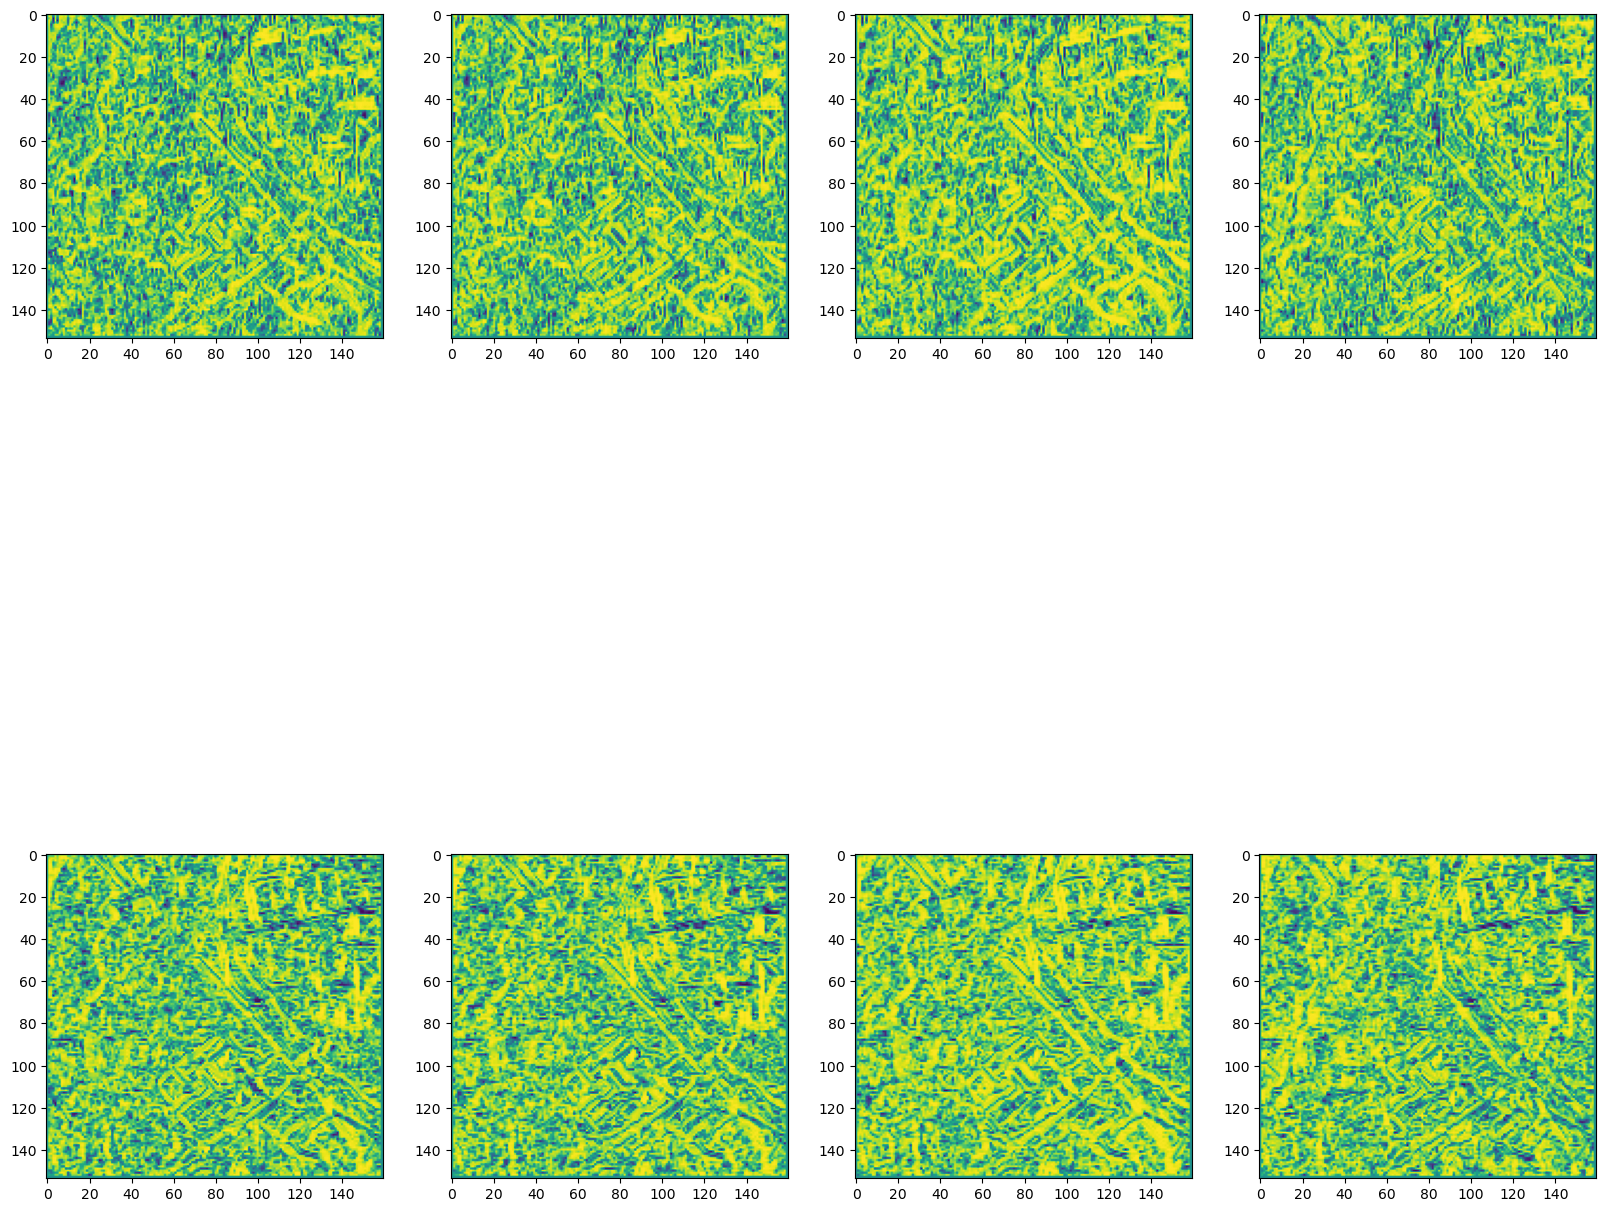

In [27]:
fig, ax = plt.subplots(2,4,figsize=(20, 20))  

for i,angle in zip(range(2),angles):
    for band in range(4):
        ax[i,band].imshow(correlation[angle][band])
plt.show()

In [ ]:
# check these are the same as X train
glcm_columns = [x + str(window_r*2+1) for x in glcm_columns]

In [21]:
window_values = []    
for angle in angles:
    for band in range(4):
        window_values.append(contrast[angle][band].reshape(y_len*x_len))

In [22]:
window_values

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [ ]:
df_window = pd.DataFrame(dict(zip(glcm_columns, window_values)))
df_window

In [ ]:
df_window.describe()